In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical

DATA_DIR = "../data"
MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)

print("Data dir:", DATA_DIR)
print("Model dir:", MODEL_DIR)


Data dir: ../data
Model dir: ../models


In [5]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Load preprocessed arrays
train_x = np.load(os.path.join(DATA_DIR, "train_x.npy"))
train_y = np.load(os.path.join(DATA_DIR, "train_y.npy"))
val_x = np.load(os.path.join(DATA_DIR, "val_x.npy"))
val_y = np.load(os.path.join(DATA_DIR, "val_y.npy"))

print("Train:", train_x.shape, train_y.shape)
print("Val:", val_x.shape, val_y.shape)

# One-hot encode labels
NUM_CLASSES = len(np.unique(train_y))
train_y_cat = to_categorical(train_y, NUM_CLASSES)
val_y_cat = to_categorical(val_y, NUM_CLASSES)

print("Classes:", NUM_CLASSES)

Train: (25838, 48, 48, 1) (25838,)
Val: (2871, 48, 48, 1) (2871,)
Classes: 7


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Fit generator to training data
datagen.fit(train_x)

In [7]:
from tensorflow.keras import layers, models

def build_model(num_classes):
    model = models.Sequential([
        layers.Input(shape=(48,48,1)),
        
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    return model

model = build_model(NUM_CLASSES)
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 64)        256       
 chNormalization)                                                
                                                     

In [8]:
from tensorflow.keras import callbacks

# Path to save the best model
ckpt_path = os.path.join(MODEL_DIR, "emotion_model.h5")

# Define callbacks
initial_lr = 0.001
lr_schedule = callbacks.LearningRateScheduler(
    lambda epoch: initial_lr * 0.95**epoch, verbose=1
)

cbs = [
    callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, "emotion_model.h5"),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    lr_schedule
]

# Train the model
history = model.fit(
    datagen.flow(train_x, train_y_cat, batch_size=128),
    validation_data=(val_x, val_y_cat),
    epochs=50,   # usually more epochs with augmentation
    callbacks=cbs,
    verbose=1
)



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50


202/202 [==============================] - ETA: 0s - loss: 2.1491 - accuracy: 0.2689
Epoch 1: val_accuracy improved from -inf to 0.25357, saving model to ../models\emotion_model.h5
202/202 [==============================] - 47s 218ms/step - loss: 2.1491 - accuracy: 0.2689 - val_loss: 4.1578 - val_accuracy: 0.2536 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.00095.
Epoch 2/50


d:\Visual Studio practice\emotion_detection\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


202/202 [==============================] - ETA: 0s - loss: 1.7146 - accuracy: 0.3862
Epoch 2: val_accuracy improved from 0.25357 to 0.33124, saving model to ../models\emotion_model.h5
202/202 [==============================] - 42s 207ms/step - loss: 1.7146 - accuracy: 0.3862 - val_loss: 1.7573 - val_accuracy: 0.3312 - lr: 9.5000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009025.
Epoch 3/50
202/202 [==============================] - ETA: 0s - loss: 1.5619 - accuracy: 0.4455
Epoch 3: val_accuracy improved from 0.33124 to 0.48241, saving model to ../models\emotion_model.h5
202/202 [==============================] - 38s 190ms/step - loss: 1.5619 - accuracy: 0.4455 - val_loss: 1.4925 - val_accuracy: 0.4824 - lr: 9.0250e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000857375.
Epoch 4/50
202/202 [==============================] - ETA: 0s - loss: 1.4935 - accuracy: 0.4776
Epoch 4: val_accuracy did not improve from 0.48241
202/202 [=========================

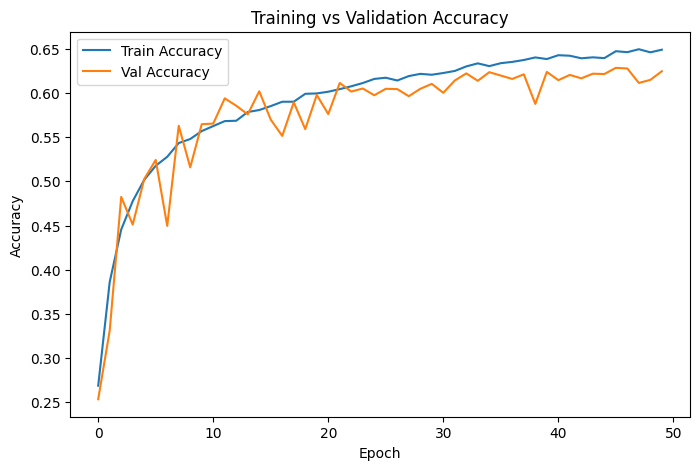

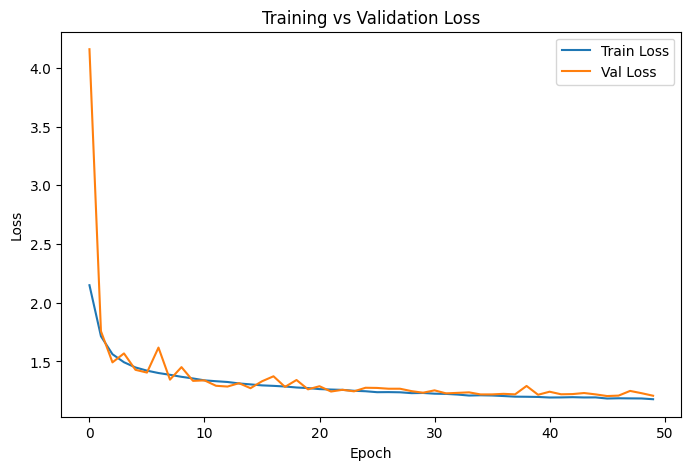

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [10]:
import os
os.makedirs("models", exist_ok=True)

# Save the model
model.save("models/emotion_model.h5")

print("Model saved successfully at models/emotion_model.h5")


Model saved successfully at models/emotion_model.h5


d:\Visual Studio practice\emotion_detection\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
